#**Lesson 8, Neuronal Nets: Gradient Descent and Logistic Regression**

In this lesson we will introduce **Neuronal Nets** using Gradient Descent and Logistic Regression.

A problem we saw with Decision Trees is that they are limited and can't extrapolate usually since they are basically doing the nearest neighbors by returning the average of the nearest points. However in most cases they can get you to the top 10% of a kaggle competition with a few tweaks which won't make you win but in real life that's already very good. Sometimes when there's a serious time component then we should aim to use neuronal nets.

##**Data Set**

Let's talk bout today's example: **recognizing numbers**. We can get okay results with Random forests but here the spacial strcture turns out to be important. A clever nearest neighbors won't work as good as a neuronal net.

An image can be defined as a **rank 2 tensor (matrix)** of pixels with 3 values: Red, Green and Blue. [0, 255] however we will se only the same representation but only for how dark our data set is using a single matrix of numbers.

In [0]:
from fastai.imports import *
from fastai.torch_core import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = 'gdrive/My\ Drive/Colab\ Notebooks/L8NN/data/'

In [0]:
PATH = PATH.replace("\\", "")
FILENAME = 'mnist.pkl.gz'
def load_mnist(filename):
  return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [0]:
((x, y), (x_valid, y_valid), _) = load_mnist(PATH+FILENAME)

We can se we just got a 50000 images of 28 by 28 as a numpy.ndarray (however it's just flatened to be 50k by 28^2) and just 50000 results for them as well.

In [0]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

##**Normalizing the data**

Several machine learning algorithms behave better when the data is **normalized**, ths is when the mean is 0 and the standard deviation is 1. In order to acheive this normalization we will substract the mean and divide by our standard deviation our data set. For random forest we never normalized since in random forest we only care about the ordering. The reason we try to normalize our data for deep learning is that we are training a parametrized model.
</br></br>
In general we need a diferent set of normalization coefficients for each thing you'ls exepct to behave diferently. Lets say we have a structured data set (income, distance, children) we need different normalization coefficients for
each of them.

</br></br>
The short answer for why do we scale and normalize data is that we are going to be doing a matrix multiply with a bunch of weights adn we will pick thos weigths in such a way that when we do the matrix multiply we are going to try to keep the numbers in the same scale as they started out as and that's going to basically require the to know the scale of the initial numbers. So basically it's easier to build a single kind of nn architecture that works for different kinds of inputs if we know that they'll consistently have a mean of 0 and std deviation of 1.

In [0]:
mean = x.mean()
std = x.std()

In [0]:
x=(x-mean)/std
mean, std, x.mean(), x.std() 

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

Now tat we did that for the training data we have to do the same for our validation data (using the same meand and standard deviation of our training data). Now we can see that this aren't as close to the desired values as our training set normalization was but they are very good so we'll keep them.

In [0]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std

(-0.005850922, <function ndarray.std>)

##**Helper Methods**

In [0]:
def show(img, title=None):
  plt.imshow(img, cmap='gray')
  if title is not None: plt.title(title)

def plots(ims, figsize=(12, 6), rows=2, titles=None):
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('Off')
    if titles is not None: sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i], cmap='gray')

##**Visualizing our data**

In [0]:
x_valid.shape

(10000, 784)

Since our data is formated as a rank 2 tensor and we are trying to display an image then we should have a rank 3 tensor: (image, rows, columns). The way we can do this is to simply reshape our numpy data.
</br> </br>
Using reshape we can tell it about only n-1 axis due to the fact that it can figure out the other axis. we should follow the order we need.


In [0]:
x_imgs = np.reshape(x_valid, (-1, 28, 28)); x_imgs.shape

(10000, 28, 28)

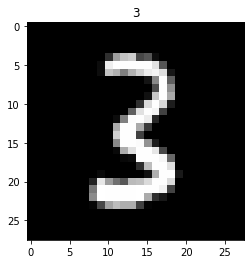

In [0]:
show(x_imgs[0], y_valid[0])

In [0]:
y_valid.shape

(10000,)

In [0]:
y_valid[0]

3

Let's look at a part of an image:

In [0]:
x_imgs[0,10:15,10:15]

array([[-0.424517, -0.424517, -0.424517, -0.424517,  0.172944],
       [-0.424517, -0.424517, -0.424517,  0.783117,  2.435669],
       [-0.424517, -0.271974,  1.202611,  2.778892,  2.804316],
       [-0.424517,  1.761937,  2.804316,  2.804316,  1.736513],
       [-0.424517,  2.206855,  2.804316,  2.804316,  0.401759]], dtype=float32)

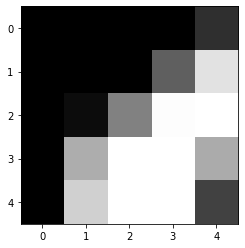

In [0]:
show(x_imgs[0,10:15,10:15])

Lets now plot some images

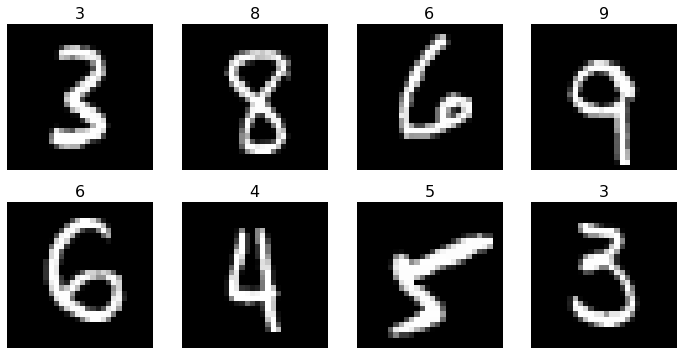

In [0]:
plots(x_imgs[:8], titles=y_valid[:8])

##**Neural Networks**

A neural network is an **infinitely** felxible matemathical function, consisting of layers. A layer is a linear function such as matric multiplication followd by a non linear funtion (the activation). This is done through matrix multiplications by column vectors usually.
</br></br>
Neural networks supports the univeral aproximation theorem which means it can approximate any function arbitrarily closely.
</br></br>
A good source to look at how NN work is: neuralnetworksanddeeplearning.com/chap4.html

A function takes inputs and retunrs outputs, for instance:

f(x) = **a**x + **b**

Machine learning is often about learning the best values for the parameters of the function, in this case, **a** and **b**.

Algorithms are used to find the 'best fit' such as **stochastic gradient descent**. This process is called training or fitting.

###**Notes on How Neural Networks work:**
http://neuralnetworksanddeeplearning.com/chap4.html

This chapter seeks to provide a 'visual' proof of the universality of neural nets, this is, that neural nets can actually approximate any given function with an epsilon > 0.

####Hidden layer structure.

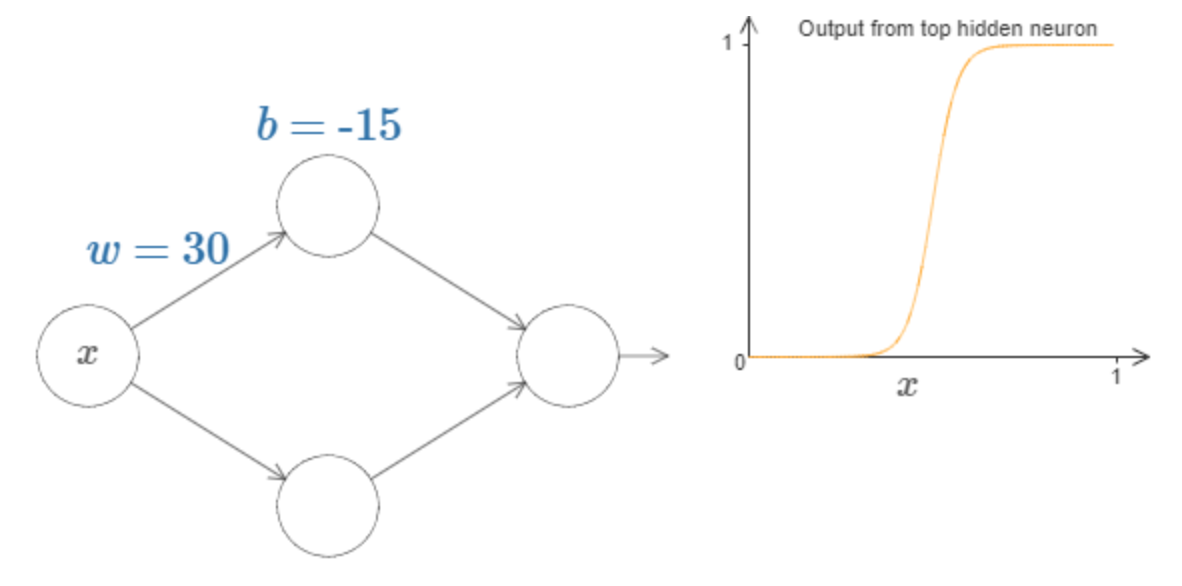

Let's define our basic structure this way were we are plotting the result of the function:


```
σ(wx+b)
```
wx+b -> simple linear function

σ -> activation function

```
σ(z) = 1/(1+e^−z)
```


#### Transofmring our function to a step function:

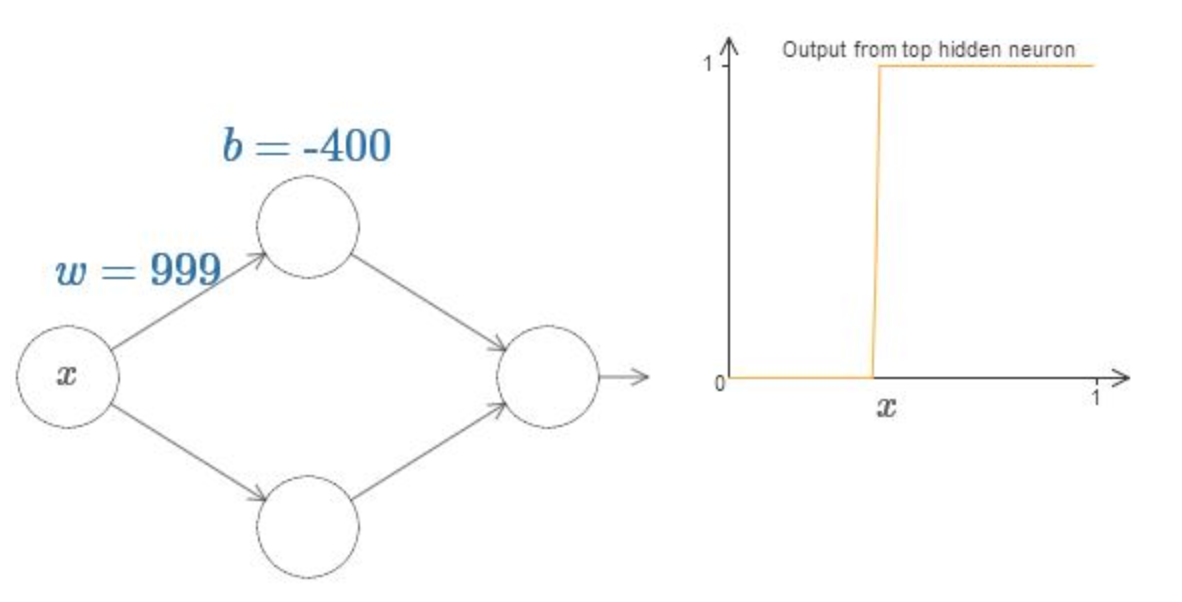

As we can see in the above image as w -> oo we will start to make our function look more and more like a **step function** which turns out very useful for our approximations.

We can always find the step in the -b/w point in our axis.

####Parametrizing our step function

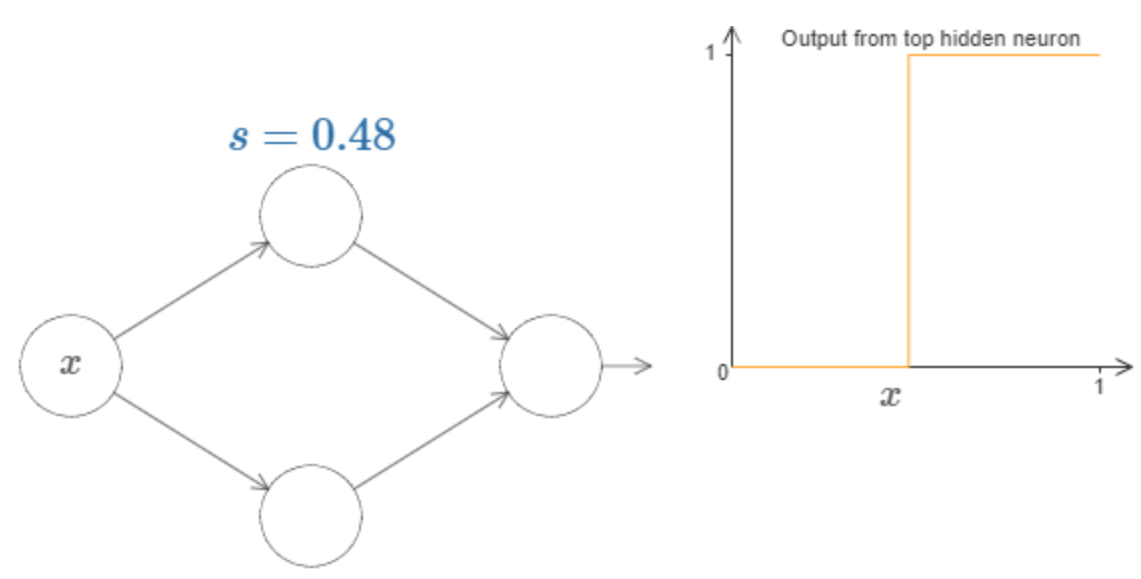

As in the above image we can start to parametrize the function on our node for it to be only dependent on where we want to put the step. Obviusly this assumes that the W from our input is actually very big. The formula for this sep will be:

```
s = -b/w
```

Something we should notice is that we can go back to the original wx+b form by simply pulling b out of the original equation:

```
b = -ws
```


####Adding more neurons to the equation

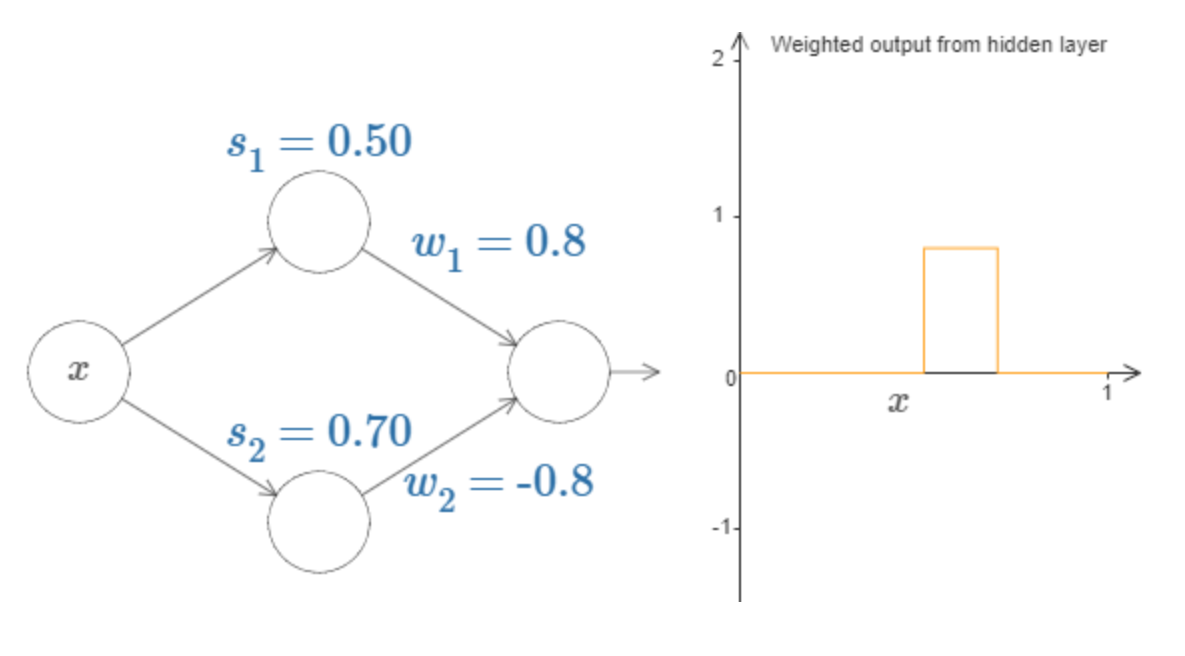

How will the **output of the layer** for several neurons?

Well the answer to this is fairly simple. The result for this will be the sum of the result of all the neurons in the layer:

```
∑j (wjaj)
```
**It's important to note that this isn't the actual output from the ouput node but rather the output from the layer befor it.**

Also the most relevant use of this sum is to form this recangular shapes werever we need with every pait of hidden neurons.

####Parametrizing the heights of our recangles (bumps) and adding more of them.

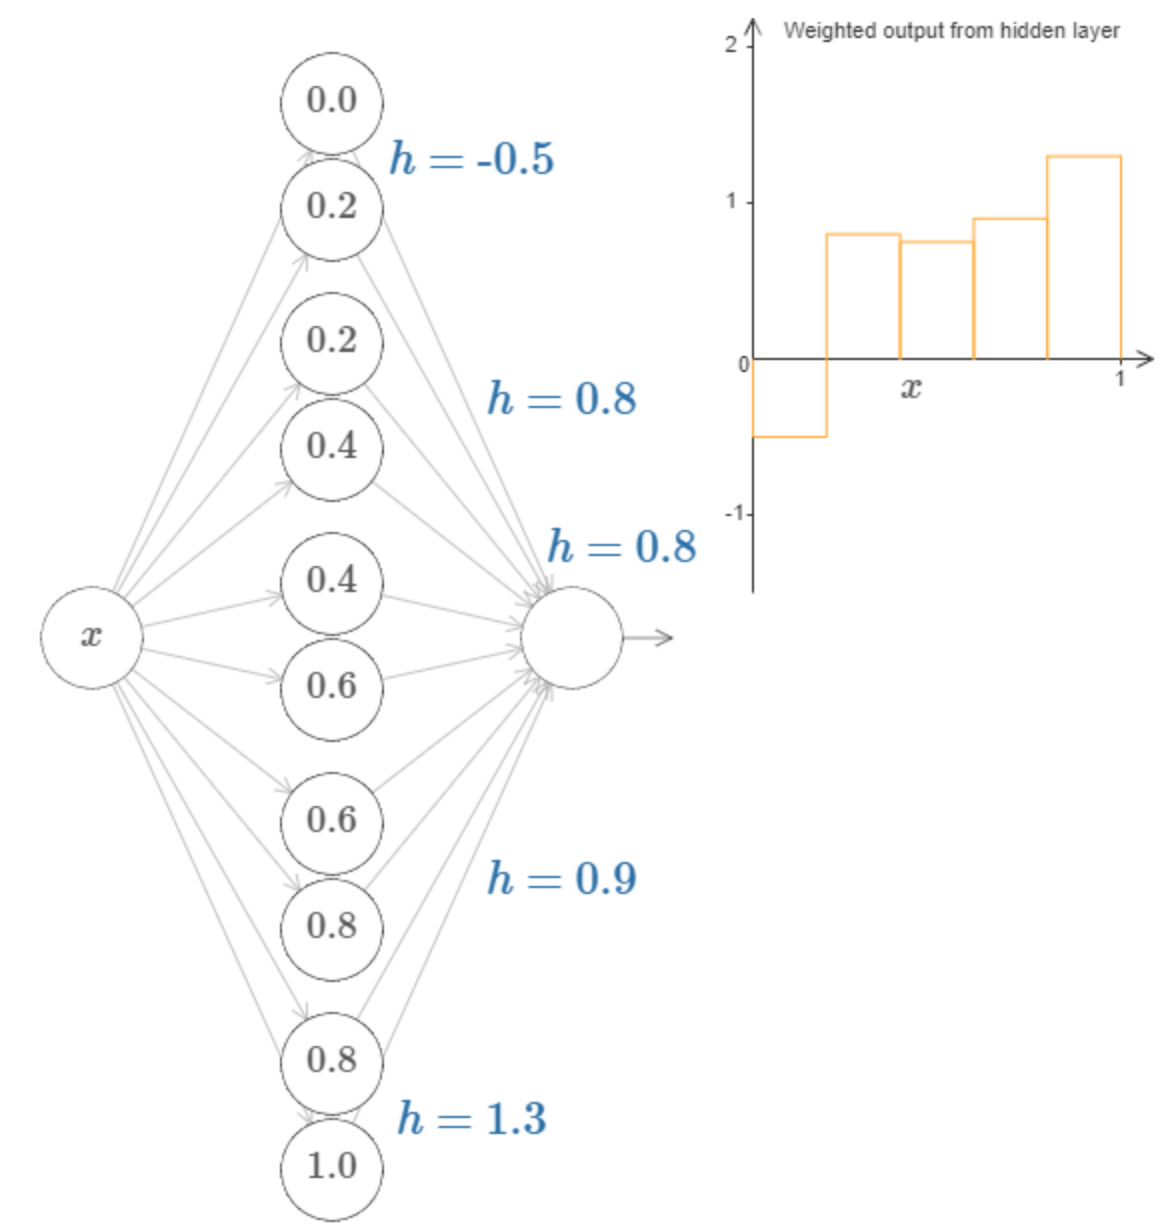

If we parametrize the height of our bumps for every pair of neurons we will be basically making the weight of each of our inputs (to the output node) +h and -h respectively.

Now a good way to distribute the step of our neurons is in differences of 1/N, N being the total number of pairs. So we will have N intervals of [0, 1/N], [1N, 2/N] ... [(N-1)/N, 1].

With this layer we can already start to approximate fairly accurately our desired function.

#### Approximating the original function

So there's a given f(x) we are currently trying to approximate. And we know the output from every node will be:

```
σ(∑(wjaj) + b)
```

So we are basically trying to make the above sigmoid function to map as close as possible our f(x).

The solution is to design a neural network whose hidden layer has a weighted output given by 


```
σ^−1 * f(x)
```


where σ^−1 is just the inverse of the σ function.


**If we can do this, then the output from the network as a whole will be a good approximation to  f(x).**

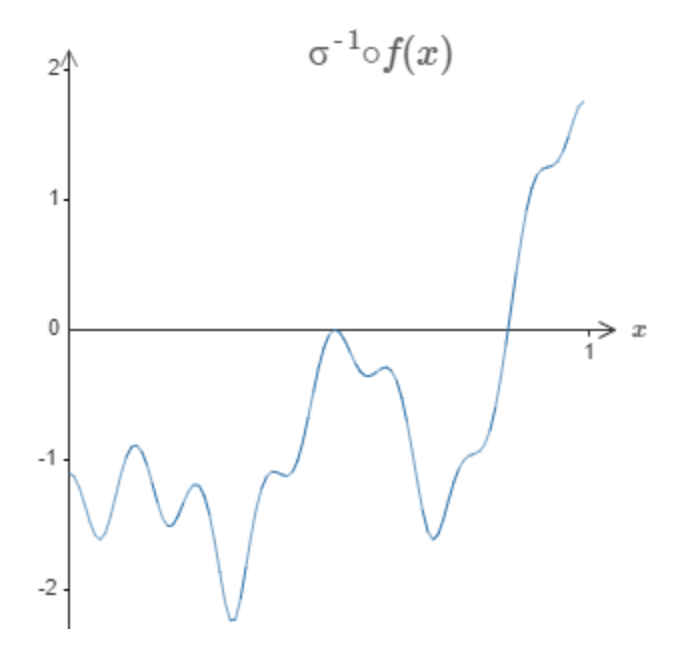

####Converting data back to the standard parameters.



1.   Assume w = 1000
2.   Biases are just b = -ws
         i.e. b = -1000*0.2 = -200
3.   The final layer weights are determined by the h values. Then Wa = h and Wb = - h

4.   We get the bias from the output neuron which in this case is basically 0.



####Many input variables (2 input case):

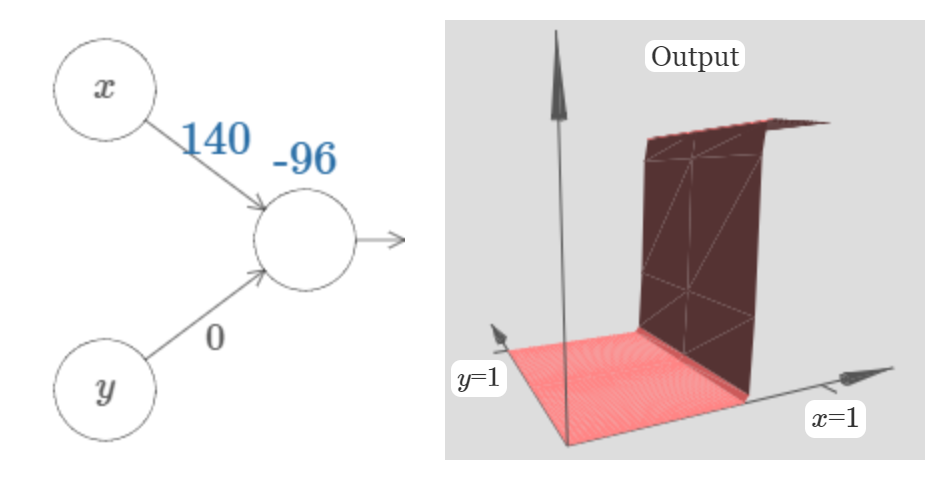

Let's first assume that Wy is 0. This will supress the changes produced by the y variable. Now we can see that what happens is we get the same step function approiximation (with a high Wx value) in the x axis which extends through the y axis.

Same goes for the Wy if we suppress the Wx:

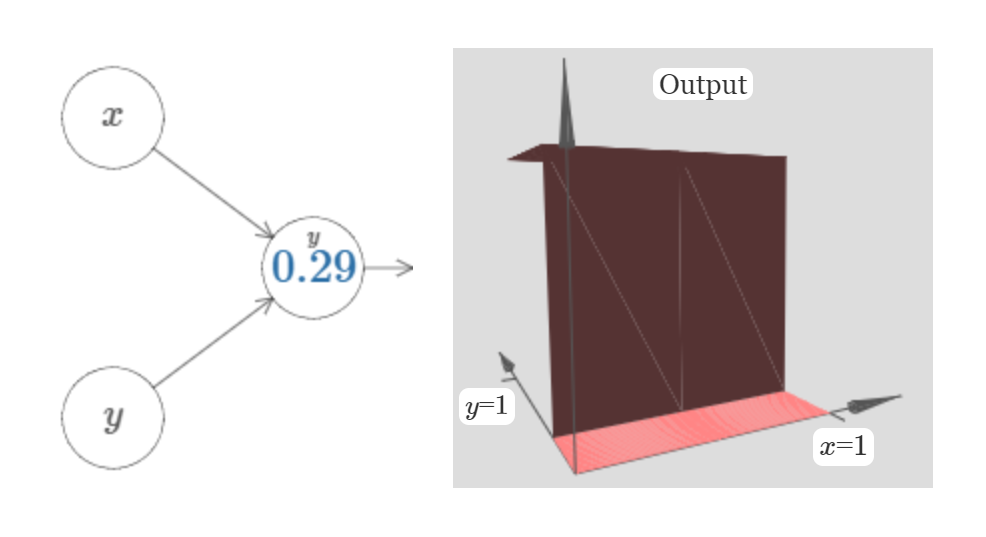

####Connecting our network (x and y values).

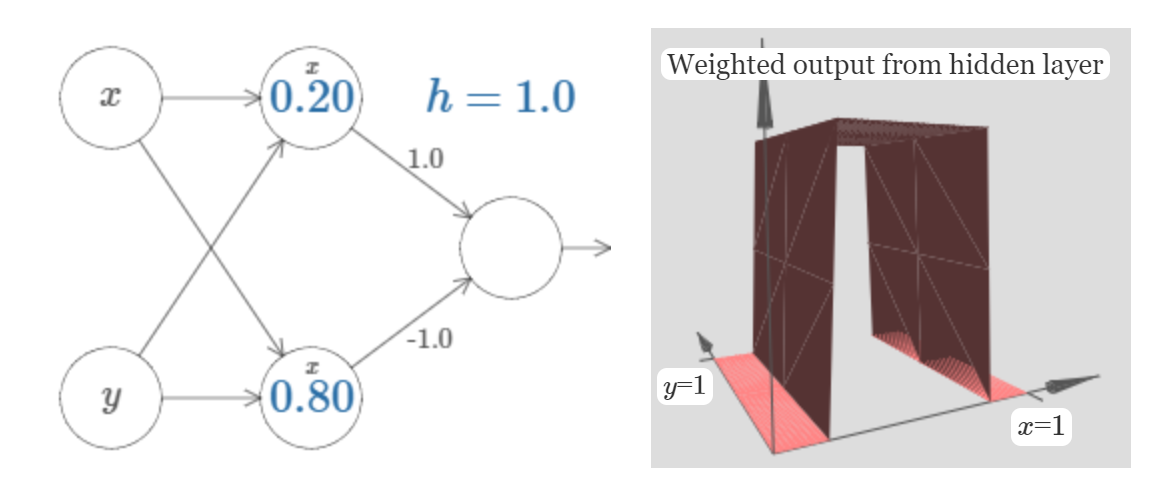

Now if we use 2 neurons for and axis then we can produce a bump in N dimensions as seen in the above example (which is supressing y and using 2 nodes to generate a bump in the x axis). Same goes for the y axis.

####Adding up both variables

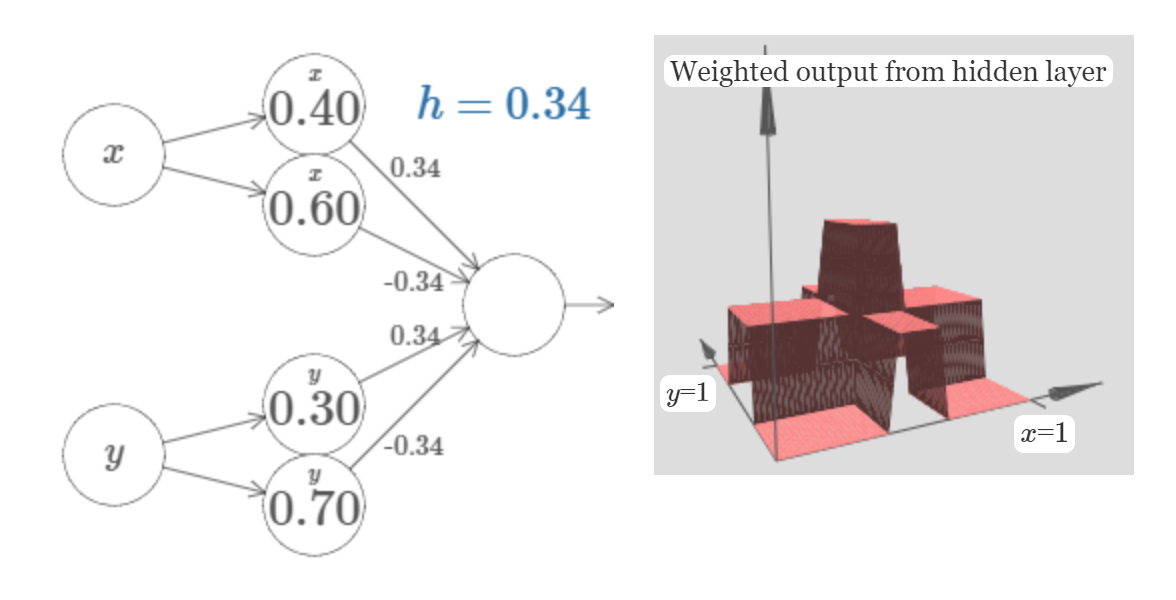

So now the simplest way to combine both the x and y axis in our output is to map a pair of neurons to each of them as shown in the picture (weighted output from the hidden layer). As we can see the cross of both bumps produces a tower with a raised floor. If we use the same heigth (as in this case) for both x and y bumps then the height of the floor will be **h** and the height of the tower in the middle will be **2h**. Also in this diagram we've dropped the connections with Wk = 0.

####Acheiving the rectancular desired shape

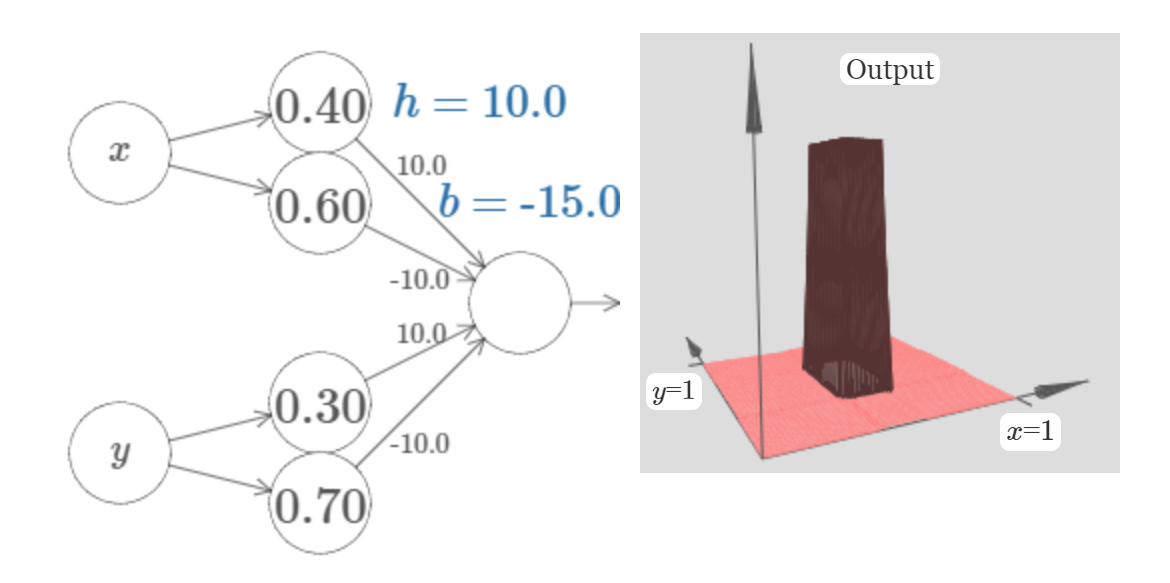

To acheive a shape such as the one on top we should consider the original function from the ouput neuron:

```
σ(∑(wjaj) + b)
```

So let's give it a try. First we should consider the height of both pairs (x and y neurons) to be the same for simplicity purposes. Now we want to reduce make the bumps outside the tower as small as possible and the way we can do this is to make the **z from our σ(z)** function as small as small (negative) as possible since our σ(z) function looks like this:

```
σ(z) = 1/(a+e^-z)
```
And this basically means that the more negative the **z** is the bigger our **e^-z** is and hence the bigger the denominator is and consecuently the smaller the value of the evaluation from the sigmoid function.

So here's where our +b from our output (before evaluating the sigmoid) is useful for. Let b equal a value around -3h/2. With this modification the bigger our h is the better aproximation we will get from a tower since this will make smaller and smaller our **σ(z)** in the bumped floor areas.



####Combining multiple pairs of neurons with multiple variables

![image.png]()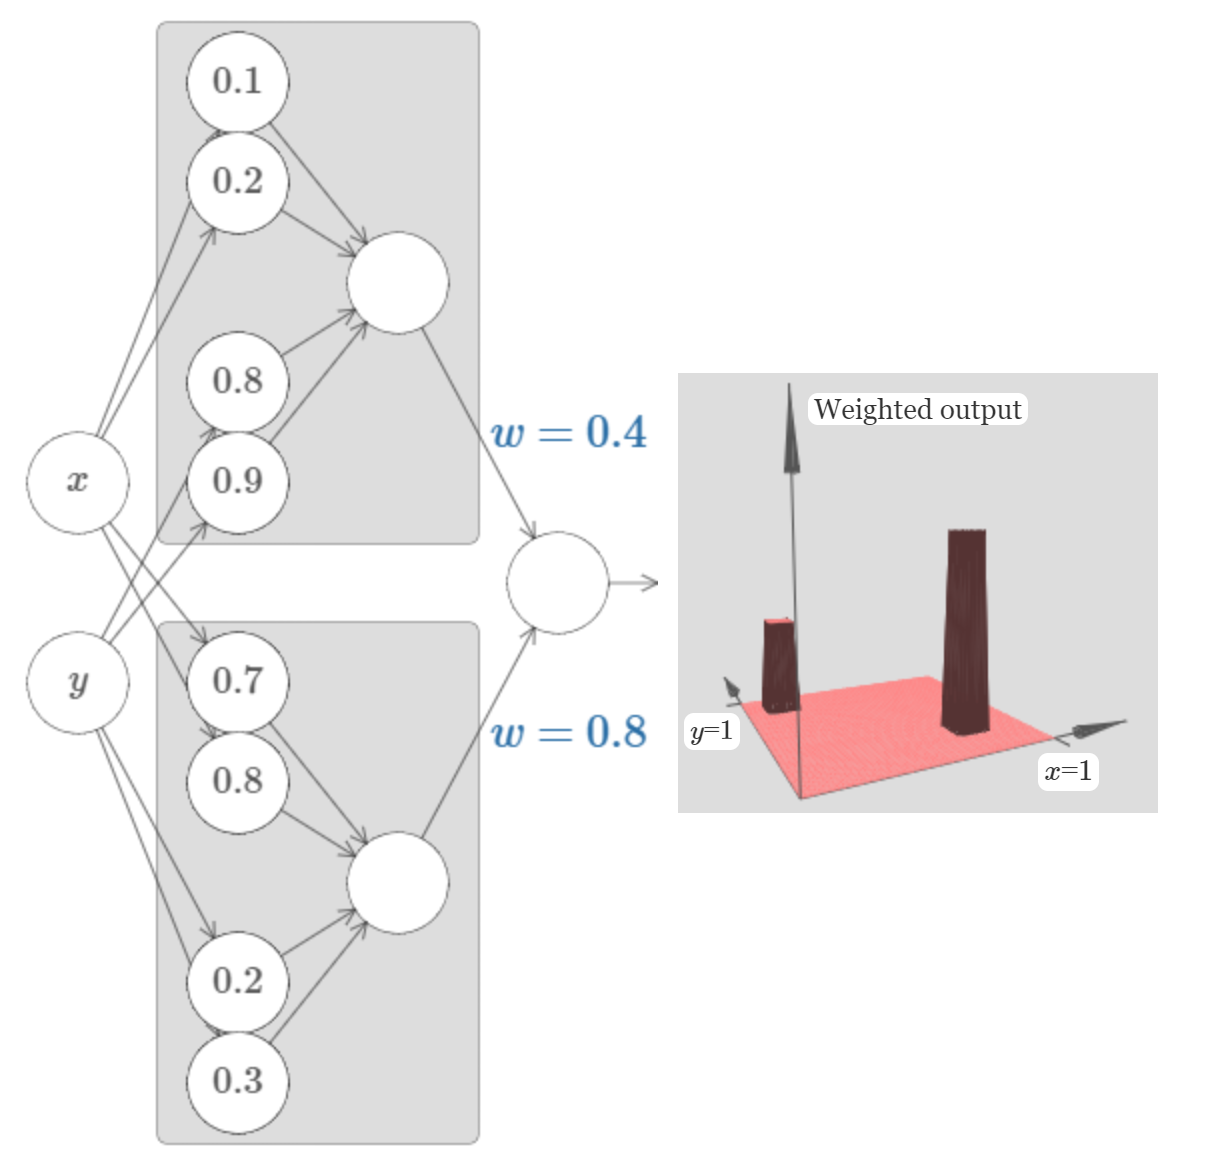

As in the above image we can achive several bumps by combining groups of neurons (in this case 2 groups of 2 neurons) in a layer and adding an extra layer at the end of both groups that adds the respective **b** value in order to flatten the undesired bumps. This same idea can be used to compute as many towers as we want and achive something like this: 

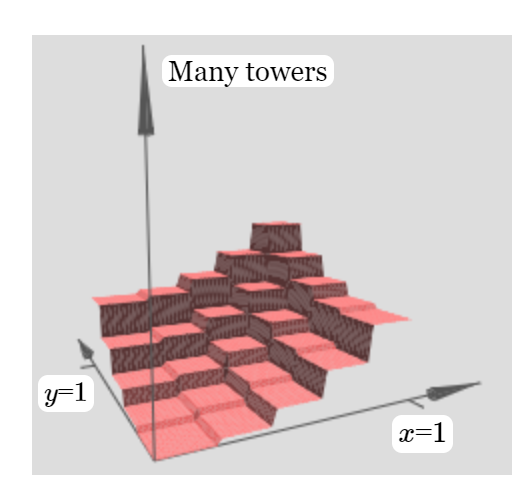

By making the weighted output from the second hidden layer as shown above a good aproximation of:


```
σ^−1 * f(x, y)
```

we ensure the final output from the network to be a good aproximation from our function f(x, y).

Something good to note is what happens when we have more than 2 variables?

Well Exactly the same idea works in m dimensions. The only change needed is to make the output bias (−m+1/2)h, in order to get the right kind of sandwiching behavior to level the plateau.



####Vector valued functions

Okay, so we now know how to use neural networks to approximate a real-valued function of many variables. What about vector-valued functions f(x1,…,xm)∈Rn? Of course, such a function can be regarded as just n separate real-valued functions, f1(x1,…,xm),f2(x1,…,xm), and so on. So we create a network approximating f1, another network for f2, and so on. And then we simply glue all the networks together. So that's also easy to cope with.

##**Pytorch**

Pytorch is a library that looks a lot like numpy but when we create code with pytorch we can run it on the GPU rather than on the CPU. This is food for neuronal nets since they use a lot of linear algebra which is easily adaptable to run on GPUs. Also since we have to know which direction and how much to move our parameters to improve our loss we have to know the derivative of functions. Pytorch has this amazing thing were any code witten using the pytorch library it can automatically take the derivative of that for you.

###**Neural Net for Logistic Regresison in PyTorch**

In [0]:
from fastai.metrics import *
from fastai.datasets import *
from fastai import *
from fastai.vision import *

import torch.nn as nn

####**Creating NN with Pytorch:**

Let's start from the highest level abstraction: using a neural net defined by Pytorch's sequential calss.

In [0]:
net = nn.Sequential(nn.Linear(28*28, 10), nn.LogSoftmax())

So the 'sequential' part here means 'I'll give you a list of the layers I want on my nural network'. So the first thing we add is the Linear layer which is basically going to do 'y = ax+b' using linear algebra. So the input to the matrix product will be a vector of 28 by 28 and the output needs to be of size 10. Then goes our non linearity which is a LogSoftMax function. The '.cuda()' tells the function to run on the GPU rather than the CPU.

In [0]:
x.shape

(50000, 784)

In [0]:
loss = nn.NLLLoss()
metric = [accuracy]
opt = optim.Adam(net.parameters())

Above we are just setting up:
* Loss function:
* Metrics:
* Optimizer: